In [1]:
import torch
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

In [2]:
"""
PCA keeping the first 3 eigenvectors.
Projects the samples in the 3D space of the eigenvectors.
This representation is adequate to visualize 'simple' features.
"""
def pca_plot(ax, dataset, title, labels=None):
    if labels is None:
        labels = dataset[1]

    X_reduced = PCA(n_components=3).fit_transform(dataset[0])
    ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=labels,
               cmap=plt.cm.Set1, edgecolor='k', s=40)
    ax.set_title(title)
    ax.set_xlabel("1st eigenvector")
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.w_zaxis.set_ticklabels([])

In [3]:
# import the iris dataset and shuffle the rows
iris = datasets.load_iris()
dataset = np.concatenate((iris.data, iris.target[np.newaxis, ...].T), axis=1)
np.random.shuffle(dataset)

# split in train and validation datasets
train_dataset = (dataset[0:100, :4], dataset[0:100, 4])
val_dataset = (dataset[100:, :4], dataset[100:, 4])

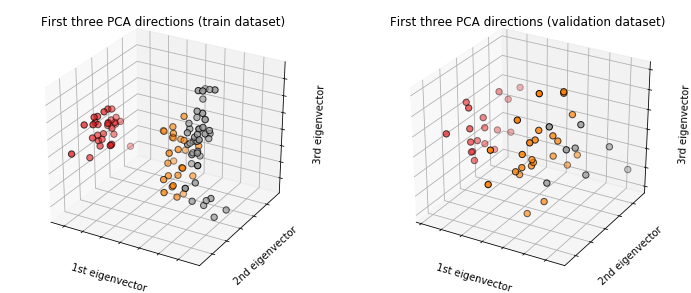

In [4]:
# plot PCA of train dataset
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
pca_plot(ax, train_dataset, "First three PCA directions (train dataset)")

# plot PCA of validation dataset
ax = fig.add_subplot(1, 2, 2, projection="3d")
pca_plot(ax, val_dataset, "First three PCA directions (validation dataset)")

plt.show()

In [5]:
n_epochs = 100
n_labels = np.unique(train_dataset[1]).shape[0]

# cast the numpy arrays to Variable, to be used for automatic differenciation (autograd)
features = torch.from_numpy(train_dataset[0]).float()
features = Variable(features)
labels = torch.from_numpy(train_dataset[1]).long()
labels = Variable(labels)

# linear encodes vector of 4 features to vector of 3 outputs
# linear = Ax + b, where A and b are learned parameters of the nn.Linear module
linear = torch.nn.Linear(features.size(1), n_labels)

# cross-entropy loss = negative_log_likelyhood(softmax())
criterion = torch.nn.CrossEntropyLoss()
# optimizer takes the parameters to tune as input and the learning rate
optimizer = torch.optim.SGD(linear.parameters(), lr=0.05, momentum=0.9)

# Training
for epoch in range(n_epochs):
    # clean gradients of parameters
    optimizer.zero_grad()

    # forward throught linear module (eq. Ax + b)
    outputs = linear(features)

    # eval loss with cross-entropy (softmax + negative log likelyhood)
    loss = criterion(outputs, labels)
    
    # eval gradients wrt each parameters
    loss.backward()

    # update parameters wrt to optimizer and gradients
    optimizer.step()
    
    # Inference
    # predicted is the index of the class with highest probability
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels.data).sum()

    if epoch % 10 == 0:
        print ('Epoch: [{}/{}], Loss: {:.4f}, Acc: {}'.format(
            epoch+1, n_epochs, loss.data[0], (100 * correct / labels.size(0))))

Epoch: [1/100], Loss: 3.0562, Acc: 26.0
Epoch: [11/100], Loss: 0.7887, Acc: 66.0
Epoch: [21/100], Loss: 0.4275, Acc: 72.0
Epoch: [31/100], Loss: 0.3077, Acc: 82.0
Epoch: [41/100], Loss: 0.2161, Acc: 96.0
Epoch: [51/100], Loss: 0.1942, Acc: 97.0
Epoch: [61/100], Loss: 0.1776, Acc: 97.0
Epoch: [71/100], Loss: 0.1670, Acc: 97.0
Epoch: [81/100], Loss: 0.1592, Acc: 97.0
Epoch: [91/100], Loss: 0.1528, Acc: 97.0


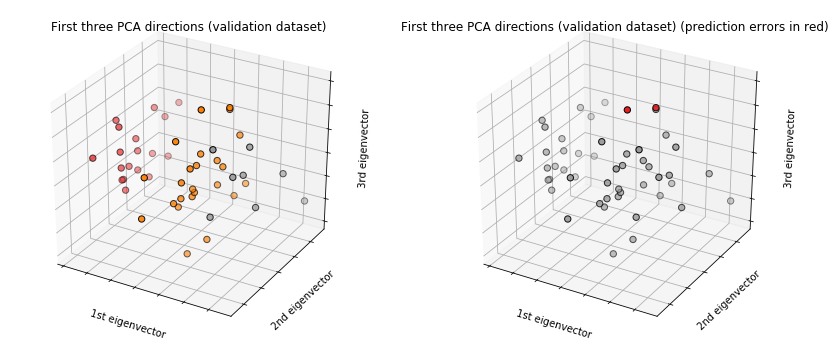

In [6]:
# inference on the validation dataset
features = Variable(torch.from_numpy(val_dataset[0]).float())
labels = Variable(torch.from_numpy(val_dataset[1]).long())
outputs = linear(features)
_, predicted = torch.max(outputs.data, 1)

# plot PCA of validation dataset
fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
pca_plot(ax, val_dataset, "First three PCA directions (validation dataset)")

# plot PCA of validation dataset, showing prediction errors in red
ax = fig.add_subplot(1, 2, 2, projection="3d")
pca_plot(ax, val_dataset,
         "First three PCA directions (validation dataset) (prediction errors in red)",
         predicted.numpy()==val_dataset[1]
        )

plt.show()